# Objective: To filter a textured image without loosing its texture

In [1]:
# Import the required libs
from torch_pdegraph.pdes import pdeanisodiff
from torch_pdegraph.utilities import *
import numpy as np
from matplotlib import image as mpimg
import faiss
import matplotlib.pyplot as plt
import torch

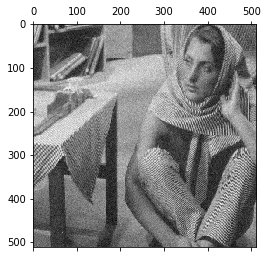

In [3]:
# load the texture based image, add some noise
# and extract patches
x = mpimg.imread("../data/barbara.png")
x = addNoise(5,x)

# feature that shall be used to create the knn-graph 
patches = imgPatches(x,(5,5))
dispImg(x)

# Create the graph
- In order to simply show the effectiveness of PDEs on graph,  I am only creating a simple K-NN based graphs. This may or maynot be the best graph for a given problem at hand.

- One can create graph using whatsoever apt approach or one can even use third-party network datasets and run a PDE on that graph.  PDEs are extensible to any given graph/network at hand as long as that graph has edges and weights( edge_index and edge_attr).

Although torch_cluster comes with a knn-graph method. I found it to be limited and  slow when the node-features have high dimensions. We shall be using facebook's faiss library which is blazingly fast for a KNN-graph construction.

In [4]:
# Create a Knn graph of the pacthes of the texture based image
# and assign weights to the edges
res = faiss.StandardGpuResources()
index = faiss.IndexFlatL2(patches.shape[1])
gpu_index_flat = faiss.index_cpu_to_gpu(res,0,index)
gpu_index_flat.add(patches.astype(np.float32))
k = 30
D, I = gpu_index_flat.search(patches.astype(np.float32),k+1)

#Graph 
edge_index = np.vstack((I[:,1:].flatten(), np.repeat(I[:,0].flatten(),k)))
#edge_attr = np.exp(-(D[:,1:].flatten()/np.inf))
edge_attr = np.ones(edge_index.shape[1]) # Let the weights be equal to 1 !
 
edge_index = torch.tensor(edge_index, dtype=torch.long).to('cuda:0')
edge_attr = torch.tensor(edge_attr, dtype=torch.float32).to('cuda:0')

edge_attr = edge_attr.view(-1,1)
graph = Graph(edge_index, edge_attr)

# Run a predefined PDE on graph :
We shall be using the following adaptive $dt$  (time step) iterative scheme for anisotropic diffusion

\begin{equation}
\mathbf{x}^{n+1}_{i} = \frac{\lambda \mathbf{x}^{0}_{i} + \sum_{j \in N(i)} w_{i,j}^{p/2}|\mathbf{x}^{n}_{j}-\mathbf{x}^{n}_{i}|^{p-2}\mathbf{x}^{n}_{j}}{\lambda+ \sum_{j \in N(i)} w_{i,j}^{p/2}|\mathbf{x}^{n}_{j}-\mathbf{x}^{n}_{i}|^{p-2}}
\end{equation}

- $\mathbf{x}_{i}$ is the node feature/signal at the $i^{th}$ node
- $w_{i,j}$ is the scalar edge_attr on the edge $e(i\to j)$

**Example:**

```python
from torch_pdegraph.pdes import pdeanisodiff
# create a pde instance
pde = pdeanisodiff.PDE(graph, **hp) 

# run the pde on the features on nodes for some iterations
new_features = pde(features, itr) 

"""
graph is a structure which has graph.edge_index and graph.edge_attr(weights)
hp is hyperparams in the equation (\lambda and p)
"""
```



The above equation is basically a gradient descent based iterative scheme on graphs for this Energy:

\begin{equation}
  \mathcal{E}_{w,p}(\mathbf{x, x^{0}, \lambda}) = \frac{\lambda}{2}\|\mathbf{x} - \mathbf{x}^{0}\|_{2}^{2} + \frac{1}{p}\sum_{i \in V}\left( \sum_{j \in N(i)} w_{i,j}^{p/2}\bigl |\mathbf{x}_{j}{-}\mathbf{x}_{i}\bigr|^p \right)
\end{equation}

To know more about it ref [Elmoataz](https://hal.archives-ouvertes.fr/hal-00163573/document)

In [5]:
#hyperparams
hp = dict(x0=torch.tensor(toFmat(x),dtype=torch.float32).cuda(), lamb=0, epsilon=5e-07, p_val=1)

# Run the implicit PDE on graph
itr = 30
features = torch.tensor(toFmat(x),dtype=torch.float32).cuda()

pde = pdeanisodiff.PDE(graph, **hp)
new_features = pde(features, itr)

100%|██████████| 30/30 [00:00<00:00, 468.53it/s]


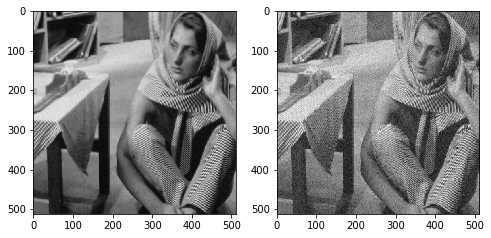

In [6]:
# Now reshape the new_features to the sqaure shape 
y = new_features.cpu().numpy()
y = toImg(y,x.shape)

#compare the noisy and filterd image
f = plt.figure(figsize=(8,8))
f.add_subplot(1,2, 1)
plt.imshow(y, cmap="gray")
f.add_subplot(1,2, 2)
plt.imshow(x, cmap="gray")
plt.show(block=True)

# Filter an image over a surface with same pde

In [7]:
# Filter an image over a surface 
p = np.load("../data/position_lena.npz")
t = np.load("../data/texture_lena.npz")
p = p["position"].astype(np.float32)
signal = t["texture"]

#param = dict(position=p, texture=signal)
#displaySur(**param)

#add noise
signal = addNoise(10, signal)

# Create a knn graph
res = faiss.StandardGpuResources()
index = faiss.IndexFlatL2(p.shape[1])
gpu_index_flat = faiss.index_cpu_to_gpu(res,0,index)
gpu_index_flat.add(p)
k = 10
_, I = gpu_index_flat.search(p,k+1)
edge_index = np.vstack((I[:,1:].flatten(), np.repeat(I[:,0].flatten(),k)))
edge_attr = np.exp(-np.sum(((signal[I]-signal[I][:,0,None])**2),axis=2)/(0.5)**2)[:,1:].flatten()
edge_index = torch.tensor(edge_index, dtype=torch.long).to('cuda:0')
edge_attr = torch.tensor(edge_attr, dtype=torch.float32).to('cuda:0')
edge_attr = edge_attr.view(-1,1)
graph = Graph(edge_index, edge_attr)

#hyperparams
hp = dict(x0=torch.tensor(signal,dtype=torch.float32).cuda(), lamb=0, epsilon=5e-07, p_val=1)

# Run the implicit PDE on graph
itr = 100
features = torch.tensor(signal,dtype=torch.float32).cuda()

pde = pdeanisodiff.PDE(graph, **hp)
new_sig = pde(features, itr)

100%|██████████| 100/100 [00:00<00:00, 1439.50it/s]


In [8]:

displayJSur(**dict(position=p, texture=new_sig.cpu().numpy()))

JVisualizer with 1 geometries

In [9]:
displayJSur(**dict(position=p, texture=signal))

JVisualizer with 1 geometries

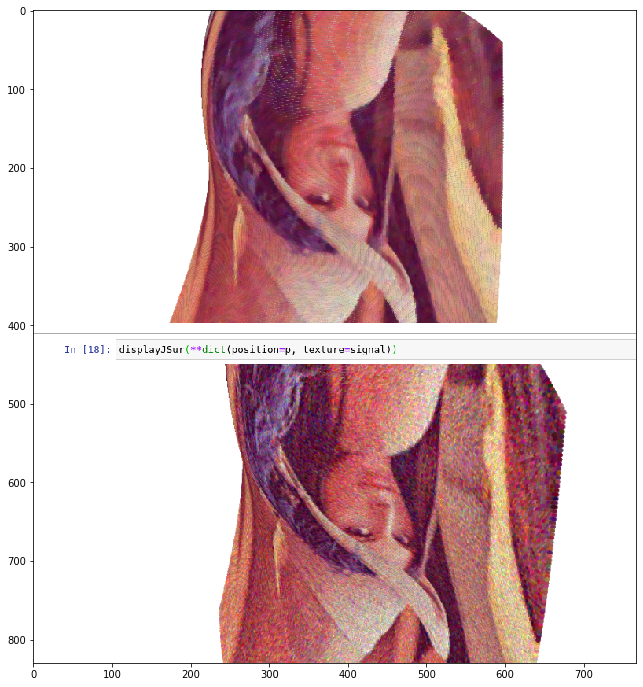

In [10]:
# Unlike an image, a pcd display cannot be saved in ipython notebook, hence the notebook must be running to 
# to view the pcd. Expect to see the surface filtered like shown in the following image.
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
res = mpimg.imread("../gallery/lena_sur.png")
f = plt.figure(figsize=(12,12))
plt.imshow(res)